In [2]:
import numpy as np
import collections
from scipy import stats
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONValueProtocol
import MRKnnTrain
import heapq
import os
from sklearn.metrics import precision_recall_fscore_support
import json
from itertools import islice
import ast
import csv
import seaborn as sn
import pandas as pd
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
true = 0
false = 0
k = 5 
model = {}
label_list=[]
freq = {} 

In [3]:
ding='utf-16') as src: #or utf-8 depending on philips or anikas env
    for line in src:
        label_model, features_model = line.split('\t')
        features_model = features_model.replace('\n', '')
        features_model = ast.literal_eval(features_model)
        label_model = ast.literal_eval(label_model)
        model[label_model] = features_model
        label_list.append(len(features_model))

<BarContainer object of 100 artists>

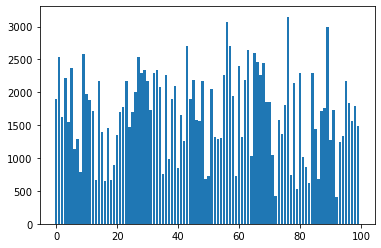

In [4]:
plt.bar(range(len(label_list)),label_list)


In [38]:
with open("./test_100.csv") as src:
    predictor_true = 0
    predictor_false = 0
    y_pred=[]
    y_label=[]
    for line in src:
        # Extract feature set and class
        data = line.split(',')
        label = data[-1]
        features = [float(x) for x in data[1:-1]] #austauschen durch lambda
        features_id = data[0]
        y_label.append(label)
        #print(data[-1])
        nearest = [] 
        count = {} 

        for cat in model:
            for point in model[cat]:
                #print(point)
                point[1:] = [float(x) for x in point[1:]]
                dis_euk = -1*np.linalg.norm(np.array(point[1:])-np.array(features), ord=2) #L2 Norm/eukl Distanz
                dis_man = -1*np.linalg.norm(np.array(point[1:])-np.array(features), ord=1) #L1 Norm/Manhatten Distanz
                dis_frobenius = -1*np.linalg.norm(np.array(point[1:])-np.array(features)) 
                item = tuple([dis_euk, point[1:], cat, point[0]])
                if(len(nearest)<k):
                    # If the nearest length is less than k, append directly
                    nearest.append(item)
                    continue
                elif(len(nearest)==k):
                    # If the nearest length is equal to k, transform the nearest into a heap
                    heapq.heapify(nearest)
                if(dis_euk > nearest[0][0]):
                    heapq.heapreplace(nearest,item)
        
        heaptemp = heapq.heappop(nearest)
        #print(range(len(nearest)))

        for i in range(len(nearest)):
            temp = heapq.heappop(nearest)
            if(temp[2] not in count):
                count[temp[2]] = 1
            else:
                count[temp[2]] += 1       
        res = max(count, key=count.get)
        y_pred.append(res)
        # Output true if the prediction is successful, otherwise false
        if(res==label):
            predictor_true += 1
        else:
            predictor_false += 1
    

In [39]:
print("Accuary:"+str(predictor_true/(predictor_true+predictor_false)*100)+"%")

accuracy2 = accuracy_score(y_label, y_pred, normalize=false)
error_rate = 1 - accuracy2
print(accuracy2, error_rate)


Accuary:0.6666666666666667%
1 0


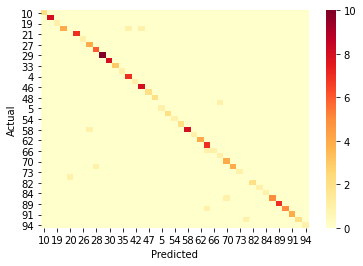

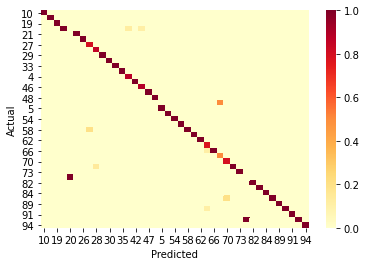

In [40]:
y_actu = [i.strip() for i in y_actu]
y_predi = pd.Series(y_pred, name='Predicted')
y_actu = pd.Series(y_actu, name='Actual')

df_confusion = pd.crosstab(y_actu, y_predi, rownames=['Actual'], colnames=['Predicted'])
df_conf_norm = df_confusion / df_confusion.sum(axis=0)

sn.heatmap(df_confusion, cmap="YlOrRd", annot=False)
plt.show()
sn.heatmap(df_conf_norm, cmap="YlOrRd", annot=False)
plt.show()


In [29]:
sum=df_confusion.sum(axis=1)

In [37]:
y_label = [i.strip() for i in y_label]
print(precision_recall_fscore_support(y_label, y_pred, average='macro'))
print(precision_recall_fscore_support(y_label, y_pred, average='micro'))
print(precision_recall_fscore_support(y_label, y_pred, average='weighted'))

(0.8033960871170173, 0.787984496124031, 0.7891733817178413, None)
(0.9, 0.9, 0.9, None)
(0.9024708994708993, 0.9, 0.8950383472736413, None)
